# Introduction to Computer Simulation via SimPy

In this practical you will learn:

* How to use `numpy` for random sampling from statistical distributions
* How to create a `simpy` environment and create basic process models
* How to model resources and simulate queues
* How to collect results from a single run of the model

## Imports

It is recommended that you use the provided environment `hds_stoch`.  Please use simpy v4.0.x and numpy v 1.18.x +

>If you are running this notebook in Google colab then `simpy` can be installed by:

```python
!pip install simpy
```

In [1]:
import simpy
simpy.__version__

'4.0.1'

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [3]:
np.__version__

'1.18.5'

## Random Sampling from Parametric Distributions in `numpy`

Before we progress to building `simpy` models we first need to explore how we can generate samples from well known statistical distributions in Python.  We will explore a range of statistical distributions in **input modelling**.  For now we will limit ourselves to some useful simple models.

In [4]:
def distribution_plot(samples, bins=100):
    '''
    helper function to visualise the distributions
    '''
    hist = np.histogram(samples, bins=np.arange(bins), density=True)
    plt.plot(hist[0]);
    plt.ylabel('p(x)');
    plt.xlabel('x');

### The `numpy.random` namespace

Python provides several libraries for random sampling.  To begin with we will work with `numpy.random`.  This has the advantage of a very simple interface.  It is also possible to control psuedo random number streams using a seed on its own or paired with a `numpy.random.Generator` object

### Simple and useful distributions

#### Exponential distribution

Useful for modelling the time between arrivals (Inter-Arrival Time; IAT). 

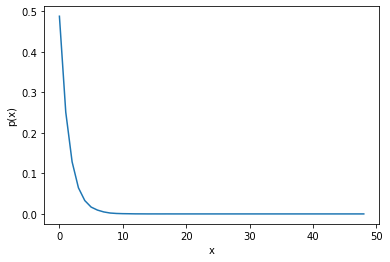

In [5]:
samples = np.random.exponential(scale=1.5, size=100000)
distribution_plot(samples, bins=50)

### Triangular distribution

Useful when not much is known about a distribution other than its likely range and the most common (mode) value.

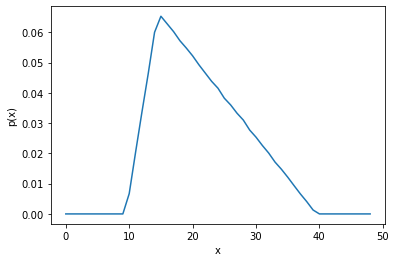

In [6]:
samples = np.random.triangular(left=10, mode=15, right=40, size=1000000)
distribution_plot(samples, bins=50)

#### Uniform distribution

Useful as an approximation when little is known, but a likely range of values

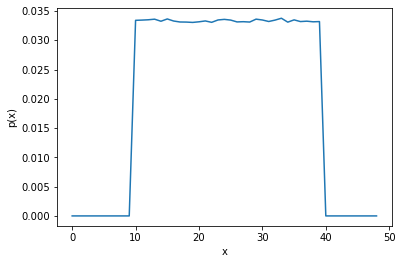

In [7]:
samples = np.random.uniform(low=10, high=40, size=1000000)
distribution_plot(samples, bins=50)

### Controlling random sampling using `np.random.seed`

We are modelling stochastic systems **BUT** our models should be controllable.  That means we should be able to rerun models and get the same results.  In simulation we do this by controlling the pseudo random number streams.

> In `numpy` one way to do this is setting a random seed.

```python
SEED = 42
np.random.seed(seed=SEED)
```
Let's create a random variable that is expontially distributed.  We will conduct two rounds of sampling. Each round will consist of two sample batches each containing 10 samples. In the first round, we will ignore the random seed.  In the second round we will set the random seed in between each the batches.


In [8]:
#round 1 => batch 1
np.random.exponential(scale=1.5, size=10)

array([0.45106615, 2.80337068, 0.59375769, 0.87672466, 2.29847143,
       2.62740655, 3.23568191, 0.84416745, 0.81623286, 0.57142696])

In [9]:
#round 1 => batch 2
np.random.exponential(scale=1.5, size=10)

array([2.30991593, 9.67370842, 0.32100968, 1.27827578, 5.26274158,
       2.43692875, 0.36173077, 0.42360909, 0.32756364, 8.51601949])

You should notice that the random samples are different.  In fact, each time you run this you will get a different result. Not let's repeat that experiment, but this time set a random seed before each batch.

In [10]:
#round 2 => batch 1
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

In [11]:
#round 2 => batch 2
np.random.seed(seed=42)
np.random.exponential(scale=1.5, size=10)

array([0.70390213, 4.51518215, 1.97511854, 1.36941383, 0.25443731,
       0.25439444, 0.08975815, 3.0168463 , 1.37862323, 1.84687509])

This time we get the same results.  Random sampling is not as random as it appears!  Always remember that simulation model is not a random game against nature.  It is a computer experiment.  **Hence it is controllable.**

### **Exercise 1**: controlled sampling from the uniform distribution

**Task:**

* Repeat the example given above, but this time use the uniform distribution.
* Use the random seed 101.  
* Try a few different seeds to check your code.
    

In [12]:
#your code here

### Complications: controlling sampling from multiple distributions

Consider a project where you are modelling a simple two stage patient pathway. 

* In the first stage of the pathway patients undergo a procedure that requires on average a 3 day spell in hospital. 
* In the second stage the patient undergos therapy at home.  On average a patient requires home therapy for 7 days.  
* A hospital is interested in what would happen to resource requirements if an intervention they have planned reduced demand on the service. 


Let's test out a simple model where we sample patients length of stay and home theory duration from two exponetial distributions.  We will use a random number seed and run two scenarios.  In the first scenario we will test sample 5 patients.  In the second we will sample 2.

In [13]:
def print_patient_details(acute, home):
    '''
    Helper function.
    Formats length of stay in data frame
    '''
    pd.set_option('precision', 2)
    df = pd.DataFrame(np.vstack([sample_acute, sample_home])).T
    df.columns = ['acute', 'home']
    return df

In [14]:
#first test - 5 patients included.
N_PATIENTS = 5
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,1.19
1,9.03,0.42
2,3.95,14.08
3,2.74,6.43
4,0.51,8.62


In [15]:
#second test - 2 patients included.
N_PATIENTS = 2
np.random.seed(42)
sample_acute = np.random.exponential(scale=3, size=N_PATIENTS)
sample_home = np.random.exponential(scale=7, size=N_PATIENTS)
print_patient_details(sample_acute, sample_home)

,acute,home
0,1.41,9.22
1,9.03,6.39


When the number of patients is reduced from 5 to 2 we get different sample values for the home therapy durations.  This is problematic because if we are not careful we may attribute improvements or lack of improvements between designs simply due to sampling variation.  

We are going to look at multiple ways to carefully analyse our model.  But for now it is useful to understand that we get this result because both distributions are using the same single stream of psuedo random numbers.  One way to solve this problem is therefore to give each distribution its **own stream**.

> In python we can do this using `numpy.random.Generator`.  We create a generator using the `numpy.random.default_rng()` function.

In [16]:
#first retest - 5 patients included.
N_PATIENTS = 5

#create two random generator objects
rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05
2,7.15,6.69
3,0.84,7.23
4,0.26,4.48


In [17]:
#second retest - 2 patients included.
N_PATIENTS = 2

#create two random state objects
rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05


Our second retest with a smaller group of patients now has the same acute and home sample values as the larger group.  We have successfully eliminated a some noise in our experiment and can more safely make statements about differences.  

> In general, it is recommended that models make use of `np.random.RandomState(seed)` over and above `np.random.seed(seed)`.  We will revisit this method later in the course and explore it in more detail.

### **Exercise 2**: controlled sampling from the uniform distribution using a RandomState object

**Task:**

* Repeat exercise 1, but make this time control sampling using a `np.random.RandomState` object.
* Use the random seed 101.  
* Try a few different seeds to check your code.

In [18]:
#your code here

### **Exercise 3**: add a third distribution to the treatment pathway example.

**Task:**

* Modify the code below to include a third random distribution and ensure that the same sample values are returned no matter how many patients are included.

In [19]:
#first retest - 5 patients included.
N_PATIENTS = 5

rs_acute = np.random.default_rng(seed=42)
rs_home = np.random.default_rng(seed=101)

sample_acute = rs_acute.exponential(scale=3, size=N_PATIENTS)
sample_home = rs_home.exponential(scale=7, size=N_PATIENTS)
#sample_gp = #your code here

print_patient_details(sample_acute, sample_home)

,acute,home
0,7.21,28.63
1,7.01,4.05
2,7.15,6.69
3,0.84,7.23
4,0.26,4.48


## Basic `simpy` models

In this course we will make use of a **free and open source** discrete-event simulation python package called `simpy`.  

> An advantage of `simpy` over commerical simulation packages is its simplicity and flexibility.  As it is part of python, it is often straightforward to use `simpy` to model complex logic and make use of the SciPy stack!  Initially, you will need to write a lot of code. But don't worry. During the course we will build a up our own library of reusable code that we can draw on (and build on) for future simulation projects.  As `simpy` is free and open it has a big advantage over commerical software for both research and health system use.  



### A first example: a hospital pharmacy

In this first example, let's assume (unrealistically) that prescriptions arrive **exactly** 5 minutes apart.  To build this model we need the following components:

#### **A simpy environment**

`simpy` has process based worldview.  These processes take place in an environment.  You can create a environment with the followinug line of code:

```python
env = simpy.Environment()
```

#### **simpy timeouts**

We can introduce **delays** or **activities** into a process.  For example these might be the duration of a stay on a ward, or the duration of a operation.  In this case we are going to introduce a delay between arrivals (inter-arrival time).  In `simpy` you control this with the following method:

```python
activity_duration = 20
env.timeout(activity_duration)
```

#### **generators**

The event process mechanism in `simpy` is implemented using python generators.  A basic generator function that yields a new arrival every 5 minutes looks like this:

```python
def prescription_arrival_generator(env):
    while True:
        yield env.timeout(5.0)
```

Notice that the generator takes the environment as a parameter.  It then internally calls the `env.timeout()` method in an infinite loop.

#### **running a `simpy` model**

Once we have coded the model logic and created an environment instance, there are two remaining instructions we need to code.

1. set the generator up as a simpy process

```python
env.process(prescription_arrival_generator(env))
```

2. run the environment for a user specified run length

```python
env.run(until=25)
```

The run method handle the infinite loop we set up in `prescription_arrival_generator`. The simulation model has an internal concept of time.  It will end execution when its internal clock reaches 25 time units.

**Now that we have covered the basic building blocks, let's code the actual model.**  It makes sense to create our model logic first.  The code below will generate arrivals every 5 minutes.  Note that the function takes an environment object as a parameter.

In [20]:
def prescription_arrival_generator(env):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    '''
    while True:
        inter_arrival_time = 5.0
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

Now that we have our generator function we can setup the environment, process and call run.  We will create a `RUN_LENGTH` parameter that you can change to run the model for different time lengths.  What would happen if this was set to 50?

In [21]:
#model parameters
RUN_LENGTH = 25

env = simpy.Environment()
env.process(prescription_arrival_generator(env))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 5.0
Prescription arrives at: 10.0
Prescription arrives at: 15.0
Prescription arrives at: 20.0
end of run. simulation clock time = 25


### **Exercise 3**: modelling a poisson arrival process for prescriptions

**Task:**

* Update `prescription_arrival_generator()` so that inter-arrival times follow an exponential distribution with a mean of 5.0 minutes between arrivals.
* Use a run length of 25 minutes.

> **Bonus**: try this initially **without** setting a random seed.  Then update the method choosing an approach to control random sampling.


In [22]:
#your code goes here

In [23]:
#example answer
def prescription_arrival_generator(env, random_seed=None):
    '''
    Prescriptions arrive with a fixed duration of
    5 minutes.
    
    Parameters:
    ------
    env: simpy.Environment
    
    random_state: int, optional (default=None)
        if set then used as random seed to control sampling.
    '''
    rs_arrivals = np.random.default_rng(random_seed)
    
    while True:
        inter_arrival_time = rs_arrivals.exponential(5.0)
        yield env.timeout(inter_arrival_time)
        print(f'Prescription arrives at: {env.now}')

In [24]:
#model parameters
RUN_LENGTH = 25
SEED = 23

env = simpy.Environment()
env.process(prescription_arrival_generator(env, random_seed=SEED))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

Prescription arrives at: 0.7378989827010132
Prescription arrives at: 2.070573882608715
Prescription arrives at: 2.6194454067498
Prescription arrives at: 6.302664339481998
Prescription arrives at: 16.936017243415527
end of run. simulation clock time = 25


### Example 2: Calling for 111

Call operators in an ambulance service recieve calls at a rate of 50 per hour. Call length can be represented by a triangular distribution.  Calls last between 0.5 minutes and 10 minutes. Most calls last 5 minutes. There are 20 call operators.  Build a `simpy` model of the process.

#### **simpy resources**

To model the call centre we need to introduce a **resource**.  If a resource is not available then a process will pause.  We create a resource as follows:

```python
operators = simpy.Resource(env, capacity=20)
```

When we want to request a resource in our process we create a with block as follows:

```python
with operators.request() as req:
    yield req
```

This tells simpy that your process needs an operator resource to progress.  The code will pause until a resource is yielded. This gives us our queuing effect.  If a resource is not available immiediately then the process will wait until one becomes available.  We will practice this alot in the course so do not worry if this does not make sense immediately.

#### **using classes to represent a process**

The first thing we will do in our modelling task is create a `Patient` class.  (Note that you could also use simpy exclusively with functions.  However, we will favour classes as this helps with thinking about design and results in cleaner code.) This represents the service process that each calling patient experiences.  Remember we declare a class in python like so: We will do this step by step.

```python
class Patient(object):
```

We will then create a constructor method and pass in a unique `identifier`, a `simpy.Environment`, and the `simpy.Resource` that represents the operators.  

```python
    def __init__(self, identifier, env, operators):
        self.identifier = identifier
        self.env = env
        self.operators = operators
```

We can then create instances of a `Patient` as follows:

```python
identifier = 1
new_caller = Patient(identifier, env, operators)
```

Lastly, we need a method that simulates the service process.  A patient caller requests an operator, waits until one is available, and then talks to the operators.  The call duration follows a triangular distribution. We will `print` details of events as the process executes.  This will include, the time a call is answered, the time a call ends (and the duration of the call).  For now we won't worry about controlling the sampling.

```python
    def service(self):
        #record the time that call entered the queue
        start_wait = env.now

        #request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at {self.env.now:.3f}')
            
            #sample call duration.
            call_duration = np.random.triangular(left=0.01, mode=0.12, right=0.16)
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; waiting time was {self.waiting_time:.3f}')

```

**The code for the full patient class is below:**

In [25]:
class Patient(object):
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, operators):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        operators: simpy.Resource
            the call operators
        '''
        self.identifier = identifier
        self.env = env
        self.operators = operators
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        #record the time that call entered the queue
        start_wait = env.now

        #request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at {self.env.now:.3f}')
            
            #sample call duration.
            call_duration = np.random.triangular(left=0.01, mode=0.12, right=0.16)
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; waiting time was {self.waiting_time:.3f}')

We need an arrival process to generate our patient callers.  This code is very similar to the code we used in our pharmacy example.  The key difference is that after each inter-arrival delay we instantiate a new `Patient` object and then pass this to the environment as a process.  We do the latter like so:

```python
identifier = 1
new_caller = Patient(identifier, env, operators)

#let the environment know that the service method is a process
env.process(new_caller.service())
```

#### **Exercise 4**: modelling the arrival of 111 calls

**Task:**
* code a function `call_source(env, operators)` to model patient arrivals.  
* the function should accept two parameters `env` (a simpy.Environment) and `operators` (a simpy.Resource).
* Hint: copy and paste the code from exercise 3 and modify it so that it creates a `Patient` object at each inter-arrival

In [26]:
#your code here

In [27]:
#example answer
def call_source(env, operators):
    '''
    IAT is exponentially distributed with mean

    Parameters:
    ------
    env: simpy.Environment

    operators: simpy.Resource
        the call operators.
    '''
    
    #counter of callers
    for caller_count in itertools.count(start=1):
        
        #100 calls per hour.  Time units are hours. Therefore time between calls is 1/100
        inter_arrival_time = np.random.exponential(1/100)
        yield env.timeout(inter_arrival_time)
        
        print(f'call arrives at: {env.now:.3f}')
        new_caller = Patient(caller_count, env, operators)
        env.process(new_caller.service())

Finally we will create our environment, operators and run our process model.  The models time units are in hours.  Let's run the model for 0.25 hours with 5 operators.  You should see that the first 5 calls are answered immediately and subsequent calls have to wait. 

> **Remember** that we are **not** controlling random sampling at the moment so each time you run the model you will get a different result!

In [28]:
#model parameters
RUN_LENGTH = 0.25
N_OPERATORS = 5

#create simpy environment and operator resources
env = simpy.Environment()
operators = simpy.Resource(env, capacity=N_OPERATORS)

env.process(call_source(env, operators))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

call arrives at: 0.002
operator answered call 1 at 0.002
call arrives at: 0.003
operator answered call 2 at 0.003
call arrives at: 0.024
operator answered call 3 at 0.024
call arrives at: 0.036
operator answered call 4 at 0.036
call 1 ended 0.043; waiting time was 0.000
call 3 ended 0.052; waiting time was 0.000
call arrives at: 0.071
operator answered call 5 at 0.071
call arrives at: 0.073
operator answered call 6 at 0.073
call arrives at: 0.075
operator answered call 7 at 0.075
call arrives at: 0.083
call arrives at: 0.086
call arrives at: 0.096
call arrives at: 0.097
call arrives at: 0.101
call arrives at: 0.105
call arrives at: 0.111
call 2 ended 0.113; waiting time was 0.000
operator answered call 8 at 0.113
call arrives at: 0.127
call arrives at: 0.134
call 5 ended 0.136; waiting time was 0.000
operator answered call 9 at 0.136
call arrives at: 0.143
call arrives at: 0.152
call arrives at: 0.154
call 6 ended 0.154; waiting time was 0.000
operator answered call 10 at 0.154
call ar

**Generating a repeatable run of the model**

In practice, it is very helpful if your model produces consistent results in a single run.  We will see later in the module why this helps with analysis of a model, but from a practical perspective it is worth noting that this helps with debugging a stochatic computational model (a lot!).

> A good way to set up your model is to give each distribution its own psuedo random number stream.  Because of the way numpy generators work it is useful to encapsulate a distributions parameters, random seed and a generator in a class.   

A simple pattern is to give each distribution class a `__init__()` method that accepts the parameters of the distribution along with an optional random seed.  For example

```python
class Exponential():
    def __init__(self, mean, random_seed=None):
        pass
```

This is convienient because we can now pass a single instance of the exponential class around the model that includes its mean, random seed and generator.  That's a lot cleaner code wise and also helps prevent bugs (for example, using the wrong mean!). 

Each distribution class should have the same interface.  To create a sample we implement a method `sample(self, size=None)` that generates one or more samples from the distribution.  

```python
    def sample(self, size=None):
        return self.rand.exponential(self.mean, size=size)
```

We can see that the code above does all of the work in the class.  It wraps the numpy rng's `exponential` function.  It pass in the mean attribute and the size parameter (if this == None then a single sample is returned).  Here's the full code:

In [29]:
class Exponential():
    '''
    Convenience class for the exponential distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Params:
        ------
        mean: float
            The mean of the exponential distribution
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.  If set to none then a unique
            sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution
        
        Params:
        -------
        size: int, optional (default=None)
            the number of samples to return.  If size=None then a single
            sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)

In [30]:
#example usage.
arrival_dist = Exponential(10, random_seed=42)
print(arrival_dist.sample())
print(arrival_dist.sample(size=4))

24.042086039659946
[23.36189656 23.84761     2.7979429   0.864374  ]


### Exercise 5: A triangular distribution class

**Task:**
    
* Create a convenience class for the triangular distribution called `Triangular`

**Hints:**

* The class will need to accept the low, high and mode of the distribution as parameters
* Use the Exponential class above as a template.  
* Make sure the class as the same interface as the exponential.  This means you can use the distributions interchangably.

In [31]:
#your code goes here

In [32]:
#example answer...
class Triangular():
    '''
    Convenience class for the triangular distribution.
    packages up distribution parameters, seed and random generator.
    '''
    def __init__(self, low, mode, high, random_seed=None):
        self.rand = np.random.default_rng(seed=random_seed)
        self.low = low
        self.high = high
        self.mode = mode
        
    def sample(self, size=None):
        return self.rand.triangular(self.low, self.mode, self.high, size=size)

**Modifying the model to work with our distribution classes**

We need to do a quick update of our model in order for it to make use of our new classes.  The `Patient` class only needs the `Triangular` distribution that represents call duration.  The first step is to modify the constructor to accept an additional argument.

```python
    def __init__(self, identifier, env, operators, call_dist):
        ...
        self.call_dist = call_dist
```

The second step is to update `Patient.service()` to sample from `self.call_dist`.  In other words we update the line:

```python
call_duration = np.random.triangular(left=0.01, mode=0.12, right=0.16)
```

to 

```python
call_duration = self.call_dist.sample()
```

The full modified code listing for `Patient` is below

In [33]:
class Patient(object):
    '''
    Encapsulates the process a patient caller undergoes when they dial 111
    and speaks to an operator who triages their call.
    '''
    def __init__(self, identifier, env, operators, call_dist):
        '''
        Constructor method
        
        Params:
        -----
        identifier: int
            a numeric identifier for the patient.
            
        env: simpy.Environment
            the simulation environment
            
        operators: simpy.Resource
            the call operators
            
        call_dist: object
            distribution that provides a sample([size]) interface for sampling
            call durations
        '''
        self.identifier = identifier
        self.env = env
        self.operators = operators
        self.call_dist = call_dist
         
    def service(self):
        '''
        simualtes the service process for a call operator
        
        1. request and wait for a call operator
        2. phone triage (triangular)
        3. exit system
        '''
        #record the time that call entered the queue
        start_wait = env.now

        #request an operator 
        with self.operators.request() as req:
            yield req
            
            #record the waiting time for call to be answered
            self.waiting_time = self.env.now - start_wait
            print(f'operator answered call {self.identifier} at {self.env.now:.3f}')
            
            #sample call duration.
            call_duration = self.call_dist.sample()
            yield self.env.timeout(call_duration)
            
            print(f'call {self.identifier} ended {self.env.now:.3f}; waiting time was {self.waiting_time:.3f}')

### Exercise 6: Updating `call_source()`

**Task:**
    
* Update call source to sample from the `Exponential` distrubution class and also pass the `Triangular` object to each `Patient` who calls in.

**Hints:**

* The function will need to accept **two** new parameters.  One will represent the arrival distribution and the other the call distribution
* Remember each `Patient` needs the **same** `Triangular` class.  You don't need (or want) to create a new one each time.  
* It might help if you copy-paste the `call_source()` and modify the existing code.

In [34]:
#your code here

In [37]:
#example answer
def call_source(env, operators, arrival_dist, call_dist):
    '''
    IAT is exponentially distributed with mean

    Parameters:
    ------
    env: simpy.Environment

    operators: simpy.Resource
        the call operators.

    arrival_dist: object
        Distribution representing the IAT.
        implemented the sample([size]) interface
     
    call_dist: object
        Distribution representing the call duration.
        implemented the sample([size]) interface
    '''
    
    #counter of callers
    for caller_count in itertools.count(start=1):
        
        inter_arrival_time = arrival_dist.sample()
        yield env.timeout(inter_arrival_time)
        
        print(f'call {caller_count} arrives at: {env.now:.3f}')
        new_caller = Patient(caller_count, env, operators, call_dist)
        env.process(new_caller.service())

If you have been following the naming suggestions for functions and classes then the code below will run your model.  If you have made different naming choices then you will need to modify it accordingly.

> The example below uses seeds to control the models sampling.  Try running it a few times - you should get the same arrival and service pattern if it is implemented correctly.  Try a few different seeds to see how queuing varies.

In [39]:
#model parameters
RUN_LENGTH = 0.25
N_OPERATORS = 5
ARRIVAL_RATE = 100
MEAN_IAT = 1 / ARRIVAL_RATE
CALL_LOW = 5 / 60
CALL_HIGH = 10 / 60
CALL_MODE = 7 / 60 

#PRNG seeds (set these = None to get different runs)
ARRIVAL_SEED = 42
CALL_SEED = 101

#create distribution object
arrival_dist = Exponential(MEAN_IAT, random_seed=ARRIVAL_SEED)
call_dist = Triangular(CALL_LOW, CALL_MODE, CALL_HIGH, random_seed=CALL_SEED)

#create simpy environment and operator resources
env = simpy.Environment()
operators = simpy.Resource(env, capacity=N_OPERATORS)

env.process(call_source(env, operators, arrival_dist, call_dist))
env.run(until=RUN_LENGTH)
print(f'end of run. simulation clock time = {env.now}')

call 1 arrives at: 0.024
operator answered call 1 at 0.024
call 2 arrives at: 0.047
operator answered call 2 at 0.047
call 3 arrives at: 0.071
operator answered call 3 at 0.071
call 4 arrives at: 0.074
operator answered call 4 at 0.074
call 5 arrives at: 0.075
operator answered call 5 at 0.075
call 6 arrives at: 0.089
call 7 arrives at: 0.104
call 8 arrives at: 0.135
call 9 arrives at: 0.136
call 10 arrives at: 0.146
call 11 arrives at: 0.147
call 12 arrives at: 0.158
call 2 ended 0.162; waiting time was 0.000
operator answered call 6 at 0.162
call 13 arrives at: 0.175
call 1 ended 0.175; waiting time was 0.000
operator answered call 7 at 0.175
call 14 arrives at: 0.179
call 5 ended 0.187; waiting time was 0.000
operator answered call 8 at 0.187
call 15 arrives at: 0.191
call 16 arrives at: 0.193
call 17 arrives at: 0.194
call 18 arrives at: 0.197
call 4 ended 0.199; waiting time was 0.000
operator answered call 9 at 0.199
call 19 arrives at: 0.206
call 3 ended 0.208; waiting time was 

#to do

1. parameter class / data class
2. observations 
3. additional logic - queue reneging

In [40]:
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

In [42]:
xx.shape

(1000, 1)

In [47]:
xy = np.linspace(0, 10, 1000).reshape(-1, 1).astype(np.float32)

In [48]:
xy.shape

(1000, 1)